Phụ lục 1: Mã nguồn bài toán Ảnh hưởng của Học vấn đến Thu nhập.

Trong nội dung Khóa luận về Suy luận nhân quả và Double Machine Learning, bài toán Ảnh hưởng của Học vấn đến thu nhập là một trong hai bài toán đề ra trong nội dung. Bài toán này xem xét ảnh hưởng của thu nhập người dân khi học vấn tăng lên, với các tham số đi kèm.

Đầu tiên, chúng ta import các thư viện cần thiết cho áp dụng các kỹ thuật. Bộ dữ liệu được tích hợp trong package causaldata, doubleml được sử dụng cho Double Machine Learning.

In [16]:
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
from causaldata import close_college
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

Chúng ta import dữ liệu bài toán từ package và mô tả dữ liệu.

In [17]:
data = close_college.load_pandas().data
df_data = pd.DataFrame(data)
df_data=df_data.dropna()
print(df_data.info())
print(df_data.head(10))
print(df_data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 3003 entries, 0 to 3009
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nearc4   3003 non-null   int8   
 1   educ     3003 non-null   int8   
 2   black    3003 non-null   int8   
 3   smsa     3003 non-null   int8   
 4   south    3003 non-null   int8   
 5   married  3003 non-null   float64
 6   exper    3003 non-null   int8   
 7   lwage    3003 non-null   float32
dtypes: float32(1), float64(1), int8(6)
memory usage: 76.2 KB
None
   nearc4  educ  black  smsa  south  married  exper     lwage
0       0     7      1     1      0      1.0     16  6.306275
1       0    12      0     1      0      1.0      9  6.175867
2       0    12      0     1      0      1.0     16  6.580639
3       1    11      0     1      0      1.0     10  5.521461
4       1    12      0     1      0      1.0     16  6.591674
5       1    12      0     1      0      1.0      8  6.214608
6       1    18   

Chúng ta sẽ biểu diễn hình ảnh cho bộ dữ liệu của bài toán. Trong đó trục hoành biểu diễn học vấn, trục tung biểu diễn mức lương. Bên cạnh đó chúng ta sẽ biểu diễn ma trận tương quan của bộ dữ liệu.

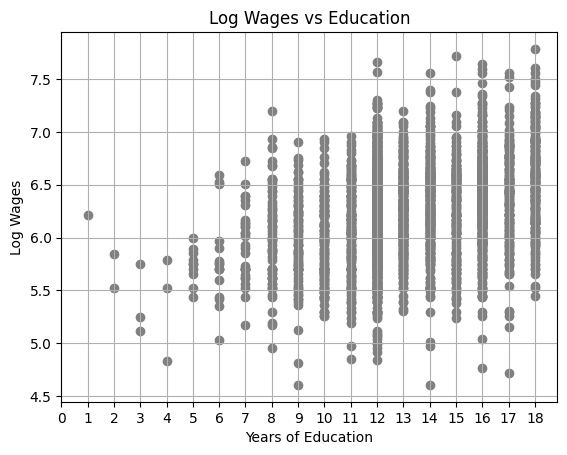

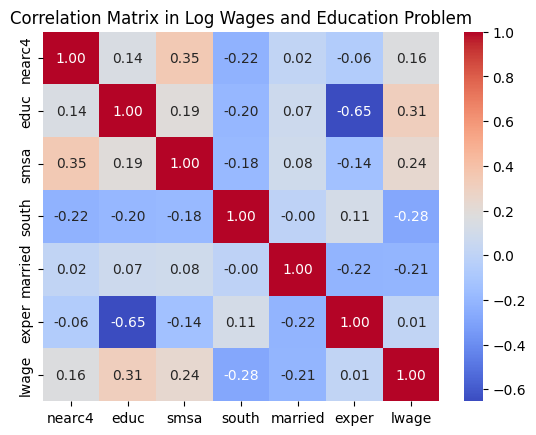

In [18]:
plt.scatter(df_data['educ'], df_data['lwage'], color='gray')
plt.title('Log Wages vs Education')
plt.xlabel('Years of Education')
plt.ylabel('Log Wages')
plt.xticks(range(0, max(df_data['educ']) + 1, 1))
plt.grid(True)
plt.show()


df_data_drop_black = df_data.drop(columns='black')
correlation_matrix = df_data_drop_black.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix in Log Wages and Education Problem')
plt.show()

Bây giờ chúng ta sẽ thực hiện Linear Regression và 2SLS cho bộ dữ liệu này tương tự như nghiên cứu của David Card.

In [19]:

X = df_data[['educ', 'exper', 'black', 'south', 'married', 'smsa', 'nearc4']]
y = df_data['lwage']

model_sklearn = LinearRegression()
X = df_data[['educ', 'exper', 'black', 'south', 'married', 'smsa', 'nearc4']]
model_sklearn.fit(X, y)
print('Hệ số của biến educ lên biến lwage:', model_sklearn.coef_[0])

Hệ số của biến educ lên biến lwage: 0.07089398007630289


In [20]:

Z = df_data[['nearc4']]
D = df_data[['educ']]
X = df_data[['exper', 'black', 'south', 'married', 'smsa']]
y = df_data['lwage']
X = sm.add_constant(X)
exog = pd.concat([D, X], axis=1)
instruments = pd.concat([Z, X], axis=1)
iv2sls = IV2SLS(y, exog, instrument=instruments).fit()
print(iv2sls.summary())


                          IV2SLS Regression Results                           
Dep. Variable:                  lwage   R-squared:                       0.251
Model:                         IV2SLS   Adj. R-squared:                  0.250
Method:                     Two Stage   F-statistic:                     139.8
                        Least Squares   Prob (F-statistic):          1.28e-156
Date:                Wed, 22 May 2024                                         
Time:                        09:21:26                                         
No. Observations:                3003                                         
Df Residuals:                    2996                                         
Df Model:                           6                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
educ           0.1242      0.050      2.485      0.0

Kết quả cho thấy hệ số của biến educ lên biến lwage trong mô hình LR là khoảng 7.1%, trong khi đối với 2SLS là 12.4%, tương tự như kết quả của Card.

Chúng ta sẽ thực hiện DML cho ước lượng ảnh hưởng của biến educ lên biến lwage. Chúng ta sẽ thực hiện 2 mô hình DML cho bài toán này: Một mô hình PLR, một mô hình PLIV.

In [22]:
feature_plr = ['exper', 'married', 'south', 'black', 'smsa', 'nearc4']
dml_data_plr_base = dml.DoubleMLData(df_data, y_col='lwage', x_cols=feature_plr, d_cols='educ')
print(dml_data_plr_base)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: lwage
Treatment variable(s): ['educ']
Covariates: ['exper', 'married', 'south', 'black', 'smsa', 'nearc4']
Instrument variable(s): None
No. Observations: 3003

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3003 entries, 0 to 3009
Columns: 8 entries, nearc4 to lwage
dtypes: float32(1), float64(1), int8(6)
memory usage: 76.2 KB



In [23]:

feature_pliv = ['exper', 'married', 'south', 'black', 'smsa']
instrument_feature = ['nearc4']
dml_data_pliv_base = dml.DoubleMLData(df_data, y_col='lwage', x_cols=feature_pliv, d_cols='educ', z_cols=instrument_feature)
print(dml_data_pliv_base)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: lwage
Treatment variable(s): ['educ']
Covariates: ['exper', 'married', 'south', 'black', 'smsa']
Instrument variable(s): ['nearc4']
No. Observations: 3003

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3003 entries, 0 to 3009
Columns: 8 entries, nearc4 to lwage
dtypes: float32(1), float64(1), int8(6)
memory usage: 76.2 KB



In [24]:
ml_l = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_m = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
np.random.seed(123)
dml_plr_obj = dml.DoubleMLPLR(dml_data_plr_base, ml_l=ml_l, ml_m=ml_m)
print(dml_plr_obj.fit())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: lwage
Treatment variable(s): ['educ']
Covariates: ['exper', 'married', 'south', 'black', 'smsa', 'nearc4']
Instrument variable(s): None
No. Observations: 3003

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_m: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.39510432]]
Learner ml_m RMSE: [[1.88230659]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
          coef   std err          t         P>|t|     2.5 %    97.5 %
educ  0.070806  0.00372

In [25]:

ml_l_rf = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_m_rf = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_r_rf = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
np.random.seed(123)
dml_pliv_obj_rf = dml.DoubleMLPLIV(dml_data_pliv_base, ml_l=ml_l_rf, ml_m=ml_m_rf, ml_r=ml_r_rf)
print(dml_pliv_obj_rf.fit())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: lwage
Treatment variable(s): ['educ']
Covariates: ['exper', 'married', 'south', 'black', 'smsa']
Instrument variable(s): ['nearc4']
No. Observations: 3003

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_m: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_r: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.39525895]]
Learner ml_m RMSE: [[0.43192447]]
Learner ml_r RMSE: [[1.88014373]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary  

Chúng ta thấy kết quả ước lượng có sự nhất quán với nghiên cứu của Card. Đối với Linear Regression, mô hình PLR cho thấy sự tương đồng, trong khi mô hình PLIV cho thấy kết quả nhất quán với nghiên cứu của Card khi xem xét biến nearc4 là biến công cụ.

In [26]:
df_summary = pd.concat((dml_plr_obj.summary, dml_pliv_obj_rf.summary))

df_summary.index = ['PLR', 'PLIV']
print(df_summary)

          coef   std err          t         P>|t|     2.5 %    97.5 %
PLR   0.070806  0.003727  18.997432  1.790962e-80  0.063501  0.078111
PLIV  0.123766  0.045021   2.749084  5.976202e-03  0.035527  0.212005


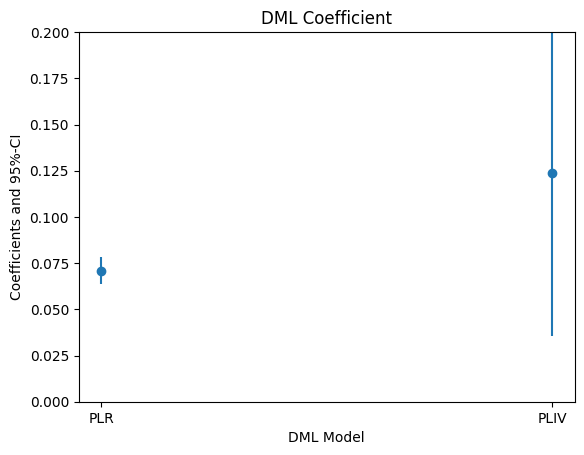

In [28]:
errors = np.full((2, df_summary.shape[0]), np.nan)
errors[0, :] = df_summary['coef'] - df_summary['2.5 %']
errors[1, :] = df_summary['97.5 %'] - df_summary['coef']
plt.errorbar(df_summary.index, df_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 0.2])

plt.title('DML Coefficient')
plt.xlabel('DML Model')
_ = plt.ylabel('Coefficients and 95%-CI')

Kết quả khoảng tin cậy cho thấy ảnh hưởng của biến educ lên biến lwage có giá trị dương, tức là học vấn tăng lên sẽ tăng thu nhập.